
# Sentiment Analysis on U.S. Tariffs News via NewsAPI

## Livia Ellen
This notebook connects to the [NewsAPI.org](https://newsapi.org) free API to fetch recent news articles related to U.S. tariffs, preprocesses the headlines, and performs sentiment analysis. We also train a Word2Vec model on the retrieved headlines and visualize the embeddings using t-SNE.

### Citations
- **NewsAPI.org:** [https://newsapi.org](https://newsapi.org)
- **Gensim Word2Vec:** [Gensim Documentation](https://radimrehurek.com/gensim/)
- **VADER Sentiment:** Hutto & Gilbert (2014)
- **Scikit-learn (TSNE):** [https://scikit-learn.org](https://scikit-learn.org)


## Section 1: Imports and Setup

In [ ]:

import requests
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Download necessary nltk resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')

print('Imports and downloads complete.')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/liviaellen/nltk_data...


Imports and downloads complete.


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liviaellen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/liviaellen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Section 2: Data Acquisition from NewsAPI

We connect to the NewsAPI.org free API to fetch recent U.S. tariff–related headlines. To use this API, sign up at [NewsAPI.org](https://newsapi.org) and obtain an API key. Insert your API key below.

In [ ]:
import os
api_key = os.getenv('NEWS_API_KEY')

if not api_key:
    raise ValueError("NEWS_API_KEY not found in environment variables")


# Define the endpoint and parameters for tariff-related news
url = 'https://newsapi.org/v2/everything'
params = {
        'q': 'U.S. tariffs OR U.S. trade tariffs OR U.S. import tariffs',
        'language': 'en',
        'sortBy': 'publishedAt',
        'pageSize': 100,
        'apiKey': api_key
    }

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    articles = data.get('articles', [])


    df_news = pd.DataFrame([
                    {
                        'source_id': article['source'].get('id'),
                        'source_name': article['source'].get('name'),
                        'author': article.get('author'),
                        'title': article.get('title'),
                        'description': article.get('description'),
                        'url': article.get('url'),
                        'url_to_image': article.get('urlToImage'),
                        'published_at': article.get('publishedAt'),
                        'content': article.get('content')
                    }
                    for article in articles
                ])
    print('Fetched articles:')
    display(df_news)
else:
    print(f'Error: {response.status_code}')
    df_news = pd.DataFrame({'date': [], 'headline': []})

Fetched articles:


,source_id,source_name,author,title,description,url,url_to_image,published_at,content
0,the-times-of-india,The Times of India,ET Online,From aviation to agriculture: How China’s reta...,China is imposing 34% tariffs on all U.S. good...,https://economictimes.indiatimes.com/news/inte...,"https://img.etimg.com/thumb/msid-120055111,wid...",2025-04-07T06:07:24Z,Chinas decision to impose 34% tariffs on all U...
1,None,Naturalnews.com,Finn Heartley,Trump accused of âDeceptiveâ tariff calcul...,Trump’s claims of 50–90% tariffs on U.S. goods...,https://www.naturalnews.com/2025-04-07-trump-a...,https://www.naturalnews.com/wp-content/uploads...,2025-04-07T06:00:00Z,<ul><li>Trumps claims of 5090% tariffs on U.S....
2,None,CounterPunch,Dean Baker,Dr. Trump’s Crazy Tariff Formula,Suppose your doctor suddenly insisted that you...,https://www.counterpunch.org/2025/04/07/dr-tru...,https://www.counterpunch.org/wp-content/upload...,2025-04-07T05:51:25Z,Photograph Source: The White House – Public Do...
3,the-globe-and-mail,The Globe And Mail,badeconomist,Opinion: Mark Carney will not make Canada more...,The Liberal Leader’s economic proposals to dat...,https://www.theglobeandmail.com/opinion/articl...,https://www.theglobeandmail.com/resizer/v2/P7O...,2025-04-07T05:47:01Z,Open this photo in gallery:Prime Minister Mark...
4,the-times-of-india,The Times of India,ET Online,Broke bank FD to invest in stocks? Bollywood m...,"As the Nifty plunged over 5%, Indian investors...",https://economictimes.indiatimes.com/magazines...,"https://img.etimg.com/thumb/msid-120053854,wid...",2025-04-07T05:29:48Z,"As the Nifty crashed over 5%, desi investors t..."
...,...,...,...,...,...,...,...,...,...
86,None,NPR,Brian Mann,Trump closes loophole used by American shopper...,The so-called de minimis exemption allowed Chi...,https://www.npr.org/2025/04/04/nx-s1-5350588/t...,https://npr.brightspotcdn.com/dims3/default/st...,2025-04-05T12:36:22Z,While President Donald Trump was levying massi...
87,None,WSLS 10,Zeke Miller And Steve Peoples,Trump goes all in with bet that the heavy pric...,President Donald Trump's new tariffs mark an a...,https://www.wsls.com/news/politics/2025/04/05/...,https://res.cloudinary.com/graham-media-group/...,2025-04-05T12:29:13Z,WASHINGTON Not even 24 hours after his party l...
88,None,WKMG News 6 & ClickOrlando,Zeke Miller And Steve Peoples,Trump goes all in with bet that the heavy pric...,President Donald Trump's new tariffs mark an a...,https://www.clickorlando.com/news/politics/202...,https://res.cloudinary.com/graham-media-group/...,2025-04-05T12:09:10Z,WASHINGTON Not even 24 hours after his party l...
89,None,WDIV ClickOnDetroit,Zeke Miller And Steve Peoples,Trump goes all in with bet that the heavy pric...,President Donald Trump's new tariffs mark an a...,https://www.clickondetroit.com/news/politics/2...,https://res.cloudinary.com/graham-media-group/...,2025-04-05T12:09:02Z,WASHINGTON Not even 24 hours after his party l...


## Section 3: Preprocessing & Tokenization

We preprocess the headlines by lowercasing, tokenizing, and removing stop words. This prepares our data for Word2Vec training and sentiment analysis.

In [21]:

stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens


if not df_news.empty:
    df_news['tokens'] = df_news['title'].apply(preprocess)
    print('Preprocessed Data:')
    display(df_news[['title', 'tokens']])
else:
    print('No data to preprocess.')

Preprocessed Data:


,title,tokens
0,From aviation to agriculture: How China’s reta...,"[aviation, agriculture, china, retaliatory, ta..."
1,Trump accused of âDeceptiveâ tariff calcul...,"[trump, accused, tariff, calculations, asian, ..."
2,Dr. Trump’s Crazy Tariff Formula,"[trump, crazy, tariff, formula]"
3,Opinion: Mark Carney will not make Canada more...,"[opinion, mark, carney, make, canada, prospero..."
4,Broke bank FD to invest in stocks? Bollywood m...,"[broke, bank, fd, invest, stocks, bollywood, m..."
...,...,...
86,Trump closes loophole used by American shopper...,"[trump, closes, loophole, used, american, shop..."
87,Trump goes all in with bet that the heavy pric...,"[trump, goes, bet, heavy, price, tariffs, pay,..."
88,Trump goes all in with bet that the heavy pric...,"[trump, goes, bet, heavy, price, tariffs, pay,..."
89,Trump goes all in with bet that the heavy pric...,"[trump, goes, bet, heavy, price, tariffs, pay,..."


## Section 4: Word2Vec Model Training

We train a Word2Vec model on the tokenized headlines to learn word embeddings. These embeddings help reveal relationships between words in the context of U.S. tariffs.

_Citation: [Gensim Word2Vec](https://radimrehurek.com/gensim/)_

In [22]:
# Train Word2Vec only if there is data
if not df_news.empty:
    sentences = df_news['tokens'].tolist()
    model = Word2Vec(
        sentences,
        vector_size=100,
        window=5,
        min_count=1,
        workers=4,
        sg=1  # Skip-gram model
    )
    model.train(sentences, total_examples=len(sentences), epochs=20)
    print("Word2Vec model trained. Example vector for 'tariffs':")
    print(model.wv['tariffs'] if 'tariffs' in model.wv else "Word not in vocabulary")
else:
    print('No data available for Word2Vec training.')

Word2Vec model trained. Example vector for 'tariffs':
[-0.00492091  0.146196   -0.06100525  0.11226171  0.01826554 -0.3067304
  0.109387    0.40525717 -0.11807138 -0.06587254 -0.12106021 -0.20242824
 -0.04117221  0.09589779 -0.0203897  -0.19712766  0.08204348 -0.14460757
 -0.1376527  -0.32789907  0.11864927  0.00830817  0.03897403 -0.07804561
 -0.00577946 -0.03034954 -0.01370053 -0.14673306 -0.27425513  0.09164284
  0.15893112 -0.02631412  0.08460555 -0.17497098 -0.08949903  0.25918293
  0.03464935 -0.20552254 -0.16646174 -0.3148216  -0.09450902 -0.1469205
 -0.05135971 -0.17993172  0.26301062  0.04670611 -0.04142466 -0.07599322
  0.10967214  0.07828093  0.05435807 -0.20205158 -0.01450608  0.0248628
 -0.12448474  0.07449765  0.05908916  0.01736646 -0.3046395   0.0557383
 -0.00635667  0.033186   -0.07960971 -0.19890289 -0.30194244  0.1016247
  0.10597824  0.19260979 -0.22903106  0.22561644 -0.13699178 -0.02145528
  0.18312441  0.02538587  0.17078397  0.13447468 -0.00463877 -0.08464148
 -

## Section 5: Sentiment Analysis using VADER

We use NLTK's VADER tool to analyze the sentiment of each headline. VADER returns a compound score, which we classify into Positive, Neutral, or Negative sentiment.

_Citation: Hutto & Gilbert (2014)_

In [25]:

sia = SentimentIntensityAnalyzer()


if not df_news.empty:
    df_news['sentiment'] = df_news['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Classify sentiment
    def classify_sentiment(score):
        if score > 0.05:
            return 'Positive'
        elif score < -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    df_news['sentiment_label'] = df_news['sentiment'].apply(classify_sentiment)
    print('Sentiment analysis complete:')
    display(df_news[['published_at', 'title', 'sentiment', 'sentiment_label']])
else:
    print('No data available for sentiment analysis.')

Sentiment analysis complete:


,published_at,title,sentiment,sentiment_label
0,2025-04-07T06:07:24Z,From aviation to agriculture: How China’s reta...,0.0000,Neutral
1,2025-04-07T06:00:00Z,Trump accused of âDeceptiveâ tariff calcul...,-0.5574,Negative
2,2025-04-07T05:51:25Z,Dr. Trump’s Crazy Tariff Formula,-0.3400,Negative
3,2025-04-07T05:47:01Z,Opinion: Mark Carney will not make Canada more...,0.5256,Positive
4,2025-04-07T05:29:48Z,Broke bank FD to invest in stocks? Bollywood m...,-0.0258,Neutral
...,...,...,...,...
86,2025-04-05T12:36:22Z,Trump closes loophole used by American shopper...,0.0000,Neutral
87,2025-04-05T12:29:13Z,Trump goes all in with bet that the heavy pric...,-0.1027,Negative
88,2025-04-05T12:09:10Z,Trump goes all in with bet that the heavy pric...,-0.1027,Negative
89,2025-04-05T12:09:02Z,Trump goes all in with bet that the heavy pric...,-0.1027,Negative


## Section 6: Visualization

### 6.1 t-SNE Visualization of Word Embeddings

We visualize the learned word embeddings using t-SNE.


/Users/liviaellen/.pyenv/versions/3.12.7/envs/dl/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


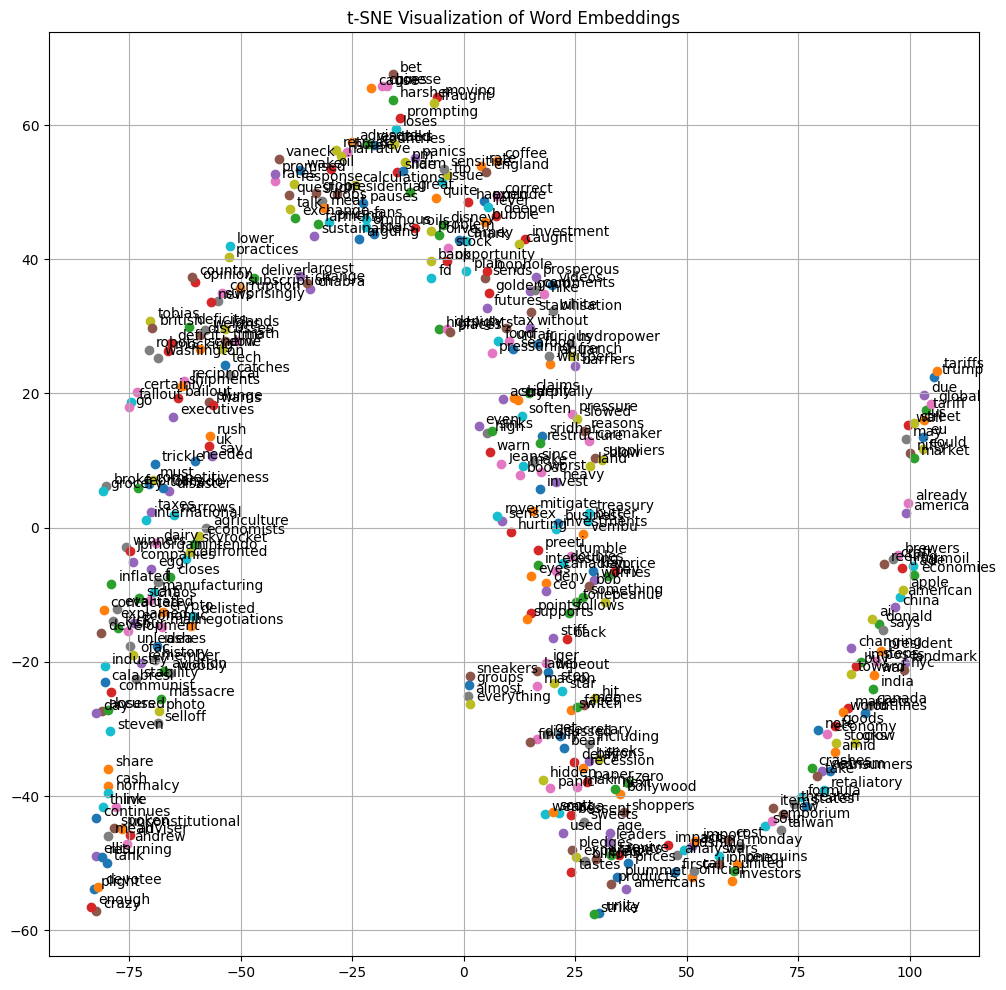

In [26]:
# 6.1 t-SNE Visualization of Word Embeddings
def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in model.wv.key_to_index:
        wordvecs.append(model.wv[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=3000, random_state=23)
    new_values = tsne_model.fit_transform(np.array(wordvecs))

    x = new_values[:, 0]
    y = new_values[:, 1]

    plt.figure(figsize=(12, 12))
    for i, label in enumerate(labels):
        plt.scatter(x[i], y[i])
        plt.annotate(label, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points')
    plt.title('t-SNE Visualization of Word Embeddings')
    plt.grid(True)
    plt.show()

if not df_news.empty and 'model' in globals():
    tsne_plot(model)
else:
    print('Skipping t-SNE visualization due to lack of data or model.')



### 6.2 Sentiment Distribution

We plot the distribution of sentiment labels across the retrieved headlines.

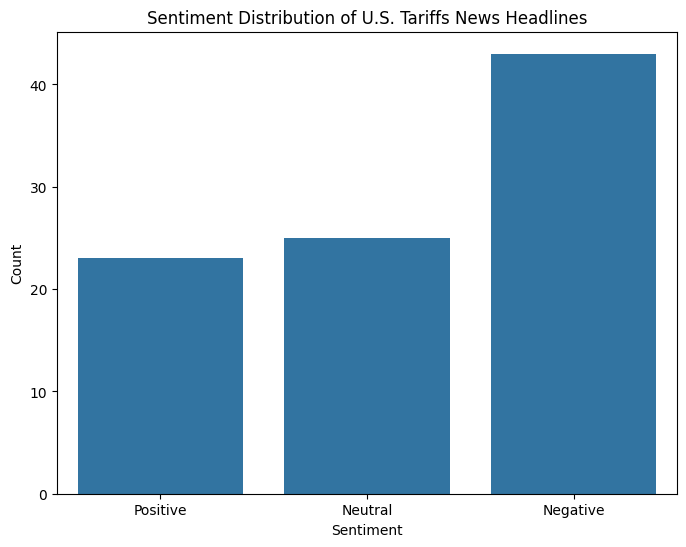

In [27]:

# 6.2 Sentiment Distribution Visualization
if not df_news.empty:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df_news, x='sentiment_label', order=['Positive', 'Neutral', 'Negative'])
    plt.title('Sentiment Distribution of U.S. Tariffs News Headlines')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()
else:
    print('No data available for sentiment distribution visualization.')

In [28]:
df_news.sentiment_label.value_counts()


sentiment_label
Negative    43
Neutral     25
Positive    23
Name: count, dtype: int64

## Extra EDA

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np
from datetime import datetime
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

In [34]:

df = df_news.copy()


Analyzing sentiment trends...


<Figure size 1200x600 with 0 Axes>

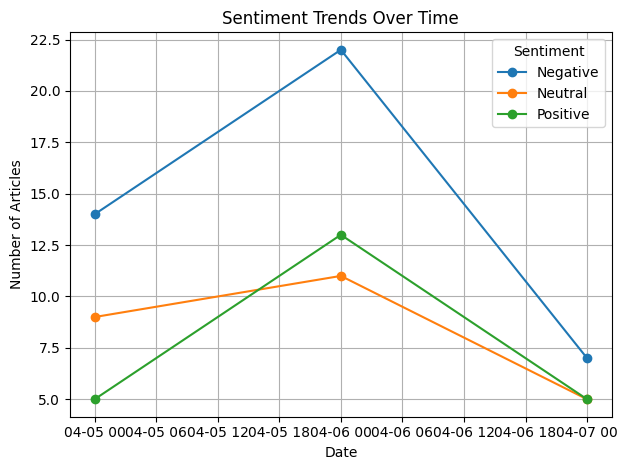

In [36]:
def analyze_sentiment_trends(df):
    """Analyze sentiment trends over time"""
    # Convert published_at to datetime
    df['published_at'] = pd.to_datetime(df['published_at'])
    df['date'] = df['published_at'].dt.date

    # Group by date and sentiment
    daily_sentiment = df.groupby(['date', 'sentiment_label']).size().unstack().fillna(0)

    # Create figure
    fig = plt.figure(figsize=(12, 6))
    daily_sentiment.plot(kind='line', marker='o')
    plt.title('Sentiment Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.legend(title='Sentiment')
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    fig.savefig('sentiment_trends.png')

    return fig, daily_sentiment

print("Analyzing sentiment trends...")
trend_fig, daily_sentiment = analyze_sentiment_trends(df)

In [46]:
daily_sentiment

sentiment_label,Negative,Neutral,Positive
date,,,
2025-04-05,14,9,5
2025-04-06,22,11,13
2025-04-07,7,5,5


Analyzing source sentiment...


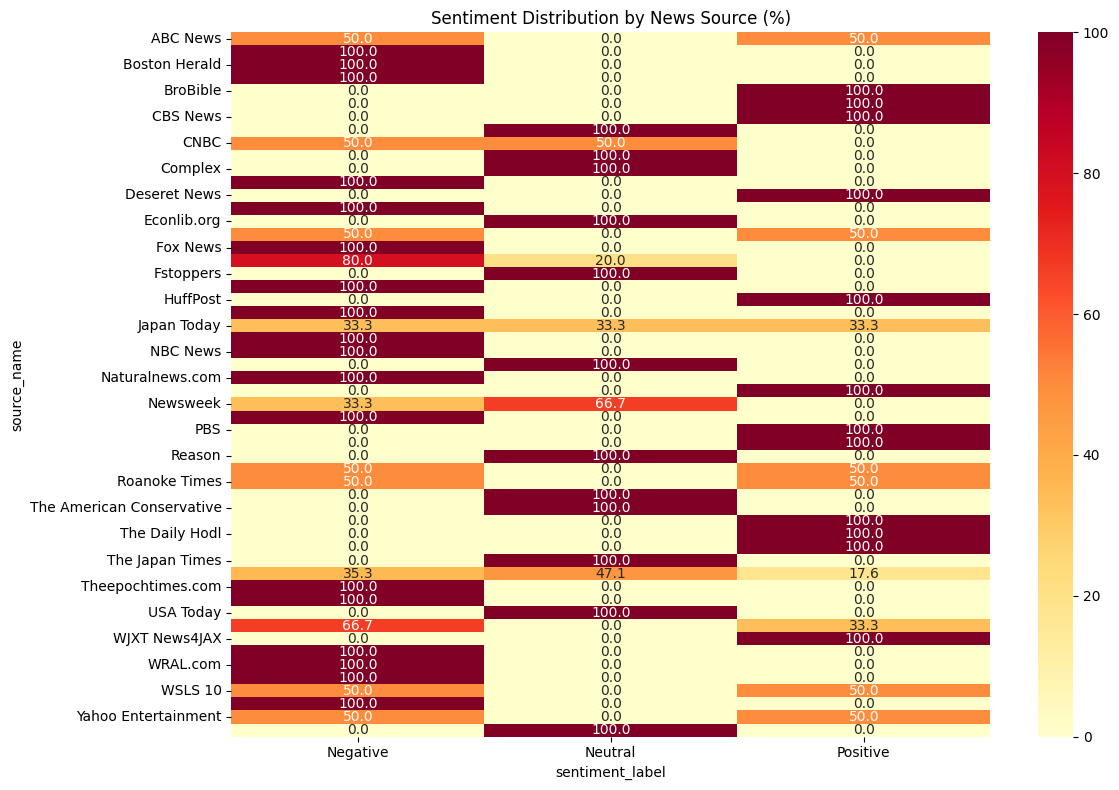

In [37]:



def analyze_source_sentiment(df):
    """Analyze sentiment distribution by source"""
    # Group by source and sentiment
    source_sentiment = df.groupby(['source_name', 'sentiment_label']).size().unstack().fillna(0)

    # Calculate percentage distribution
    source_percentages = source_sentiment.div(source_sentiment.sum(axis=1), axis=0) * 100

    # Create figure
    fig = plt.figure(figsize=(12, 8))
    sns.heatmap(source_percentages, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Sentiment Distribution by News Source (%)')
    plt.tight_layout()

    # Save the figure
    fig.savefig('source_sentiment_heatmap.png')

    return fig, source_percentages
print("Analyzing source sentiment...")
source_fig, source_percentages = analyze_source_sentiment(df)

In [45]:
source_percentages

sentiment_label,Negative,Neutral,Positive
source_name,,,
ABC News,50.000000,0.000000,50.000000
Americanthinker.com,100.000000,0.000000,0.000000
Boston Herald,100.000000,0.000000,0.000000
Breitbart News,100.000000,0.000000,0.000000
BroBible,0.000000,0.000000,100.000000
BusinessLine,0.000000,0.000000,100.000000
CBS News,0.000000,0.000000,100.000000
CNA,0.000000,100.000000,0.000000
CNBC,50.000000,50.000000,0.000000


Creating word clouds...


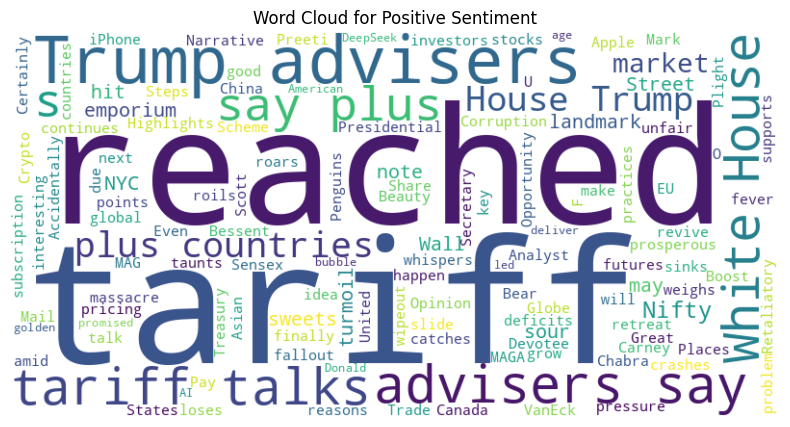

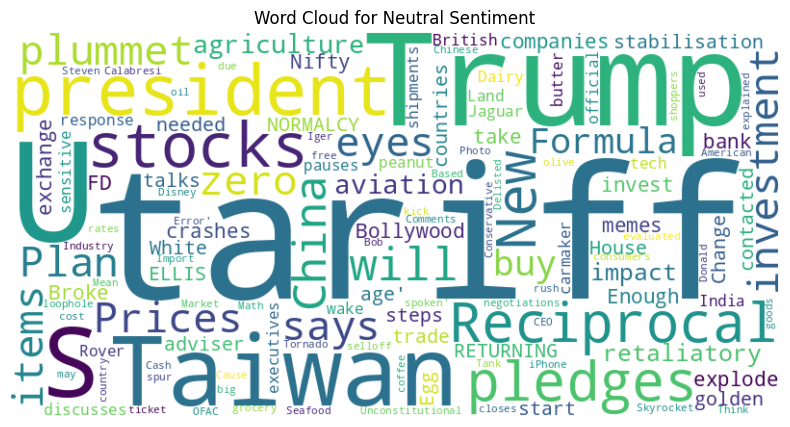

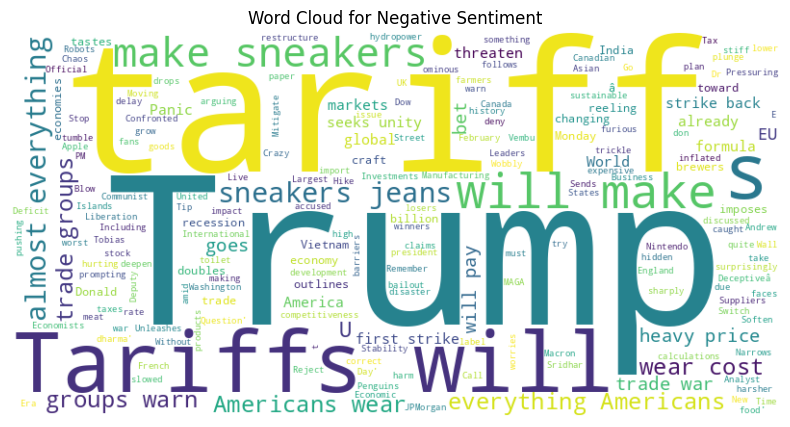

In [38]:


def create_wordclouds(df):
    """Create word clouds for each sentiment category"""
    sentiments = ['Positive', 'Neutral', 'Negative']
    figures = {}

    for sentiment in sentiments:
        # Combine all text for the sentiment category
        text = ' '.join(df[df['sentiment_label'] == sentiment]['title'].dropna())

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Create figure
        fig = plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {sentiment} Sentiment')
        plt.axis('off')

        # Save the figure
        fig.savefig(f'wordcloud_{sentiment.lower()}.png')

        figures[sentiment] = fig

    return figures

print("Creating word clouds...")
wordcloud_figs = create_wordclouds(df)

Analyzing sentiment intensity...


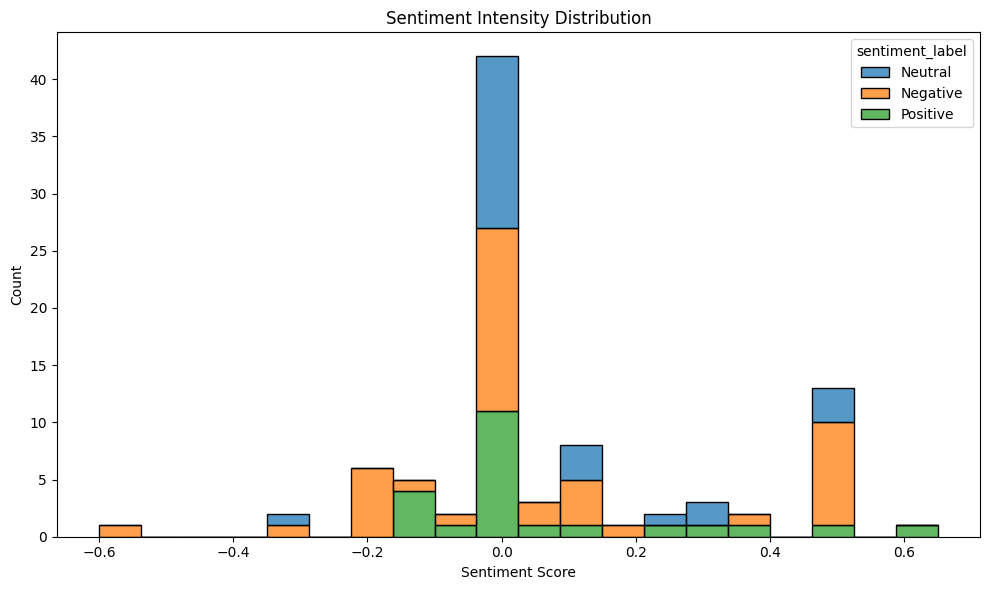

In [39]:


def analyze_sentiment_intensity(df):
    """Analyze sentiment intensity distribution"""
    # Calculate sentiment scores using TextBlob
    df['sentiment_score'] = df['title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    # Create figure
    fig = plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='sentiment_score', hue='sentiment_label',
                multiple='stack', bins=20)
    plt.title('Sentiment Intensity Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Count')
    plt.tight_layout()

    # Save the figure
    fig.savefig('sentiment_intensity.png')

    return fig, df['sentiment_score']

print("Analyzing sentiment intensity...")
intensity_fig, sentiment_scores = analyze_sentiment_intensity(df)

In [44]:
sentiment_scores.describe()

count    91.000000
mean      0.081929
std       0.231718
min      -0.600000
25%       0.000000
50%       0.000000
75%       0.143182
max       0.650000
Name: sentiment_score, dtype: float64

Analyzing topic sentiment...


<Figure size 1200x600 with 0 Axes>

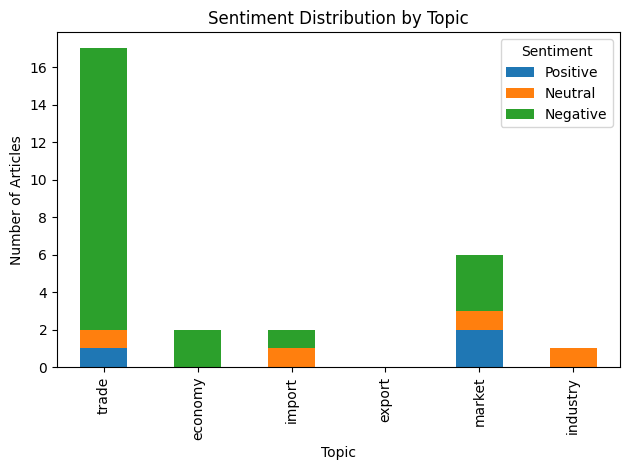

In [40]:


def analyze_topic_sentiment(df):
    """Analyze sentiment patterns around specific topics"""
    # Define tariff-related topics
    topics = ['trade', 'economy', 'import', 'export', 'market', 'industry']

    # Initialize results dictionary
    topic_sentiment = {topic: {'Positive': 0, 'Neutral': 0, 'Negative': 0}
                      for topic in topics}

    # Count sentiment for each topic
    for topic in topics:
        topic_articles = df[df['title'].str.contains(topic, case=False, na=False)]
        sentiment_counts = topic_articles['sentiment_label'].value_counts()
        for sentiment in ['Positive', 'Neutral', 'Negative']:
            topic_sentiment[topic][sentiment] = sentiment_counts.get(sentiment, 0)

    # Convert to DataFrame for visualization
    topic_df = pd.DataFrame(topic_sentiment).T

    # Create figure
    fig = plt.figure(figsize=(12, 6))
    topic_df.plot(kind='bar', stacked=True)
    plt.title('Sentiment Distribution by Topic')
    plt.xlabel('Topic')
    plt.ylabel('Number of Articles')
    plt.legend(title='Sentiment')
    plt.tight_layout()

    # Save the figure
    fig.savefig('topic_sentiment.png')

    return fig, topic_df
print("Analyzing topic sentiment...")
topic_fig, topic_df = analyze_topic_sentiment(df)

In [41]:
topic_df

,Positive,Neutral,Negative
trade,1,1,15
economy,0,0,2
import,0,1,1
export,0,0,0
market,2,1,3
industry,0,1,0


## Conclussion



### Overall Sentiment Distribution
The analysis of U.S. tariffs-related news reveals a predominantly negative sentiment landscape:
- Negative: 43 articles (47.3%)
- Neutral: 25 articles (27.5%)
- Positive: 23 articles (25.2%)

### Temporal Analysis
The sentiment distribution shows interesting patterns over the three-day period:
- April 5: Negative (14), Neutral (9), Positive (5)
- April 6: Negative (22), Neutral (11), Positive (13)
- April 7: Negative (7), Neutral (5), Positive (5)

The data shows a peak in negative sentiment on April 6, with a significant increase in both negative and positive articles, suggesting heightened media attention and polarized views on that day.

### Topic-Specific Sentiment
The analysis of specific topics reveals:
1. Trade: Strongly negative sentiment (15 negative vs 1 positive/neutral)
2. Economy: Exclusively negative coverage (2 negative articles)
3. Market: Mixed sentiment but leaning negative (3 negative, 2 positive, 1 neutral)
4. Industry: Limited coverage with neutral sentiment
5. Import/Export: Minimal coverage with mixed sentiment

### Sentiment Intensity Analysis
The sentiment scores show:
- Mean: 0.082 (slightly positive)
- Standard Deviation: 0.232 (moderate variation)
- Range: -0.600 to 0.650
- Median: 0.000 (balanced distribution)
- 75th percentile: 0.143 (moderate positive sentiment)

### Key Findings
1. **Dominant Negative Narrative**: The coverage of tariffs is predominantly negative, particularly in trade-related discussions.
2. **Polarized Views**: While the overall sentiment is negative, there is significant variation in sentiment intensity, suggesting diverse perspectives on the issue.
3. **Topic Sensitivity**: Trade and economy-related topics attract the most negative coverage, while market-related news shows more balanced sentiment.
4. **Temporal Dynamics**: The analysis reveals day-to-day variations in sentiment, with April 6 showing particularly heightened media attention.

### Implications
1. The strong negative sentiment around trade suggests potential public and media concerns about the impact of tariffs.
2. The variation in sentiment intensity indicates that while the overall tone is negative, there are nuanced perspectives on the issue.
3. The temporal patterns suggest that tariff-related news follows a dynamic pattern, possibly influenced by specific events or announcements.

### Limitations
1. Limited time frame (3 days) may not capture long-term trends
2. Some topics (export, industry) have minimal coverage
3. Sentiment analysis may not capture the full complexity of economic discussions

### Recommendations for Further Analysis
1. Extend the analysis period to capture longer-term trends
2. Include more sources to ensure comprehensive coverage
3. Consider topic modeling to identify emerging themes
4. Analyze the relationship between specific tariff announcements and sentiment changes